In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# From the SK model to matrix factorization

## The planted SK model

$$\left\{
\begin{aligned}
    &x_i \sim \frac12 \, \delta(x_i - 1) + \frac12 \, \delta (x_i + 1), \quad i \in [N], \\
    &J_{ij} \sim \mathcal{N} (x_i x_j, \sigma^2), \quad (i, j) \in [N]^2.
\end{aligned}
\right.
$$

$$P({\bf x} | J) = \frac{P({\bf x}, J)}{P (J)} \propto \prod_{ij} P(J_{ij} | x_i, x_j) \, \prod_i P_0 (x_i) \propto \exp \bigg\{\beta \sum_{ij} J_{ij} x_i x_j\bigg\}$$

Let us first write a function to sample an instance $\{{\bf x}, J\}$ for us: it first samples ${\bf x} \sim U(\{-1, +1\}^N)$, then generates $J$ by setting $J_{ij} = x_i x_j + \mathcal{N} (0, \sigma^2_{ij})$.

In [2]:
def sample_instance(size_x, var_noise):
    # Sample x from U({+1, -1}^N)
    x0 = np.random.choice([+1, -1], size_x)
    
    # Generate J = xx^T / sqrt(N) + noise
    W = np.outer(x0, x0) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_x, size_x)
    #noise = np.tril(noise) + np.tril(noise).T  # make noise symmetric
    
    J = W + noise

    return x0, J

In [3]:
x0, J = sample_instance(size_x=5000, var_noise=0.1)
print(x0)
print(J)

[ 1 -1  1 ...  1 -1 -1]
[[ 0.17893552  0.18989295  0.18983969 ...  0.04486549  0.33898349
   0.05925263]
 [ 0.14361858 -0.09405477  0.0475466  ...  0.32294519  0.01978119
   0.02602182]
 [-0.36617599 -0.32721196 -0.24677654 ...  0.27745417 -0.51757941
   0.12879451]
 ...
 [-0.04699868  0.36569576 -0.15944852 ... -0.05410941 -0.12207424
  -0.16803076]
 [-0.20651937 -0.05921181  0.34254108 ... -0.14424313  0.62471291
   0.30912637]
 [-0.08071995 -0.05231012 -0.50576127 ...  0.26066376  0.11437594
   0.31817798]]


In [4]:
def iterate_amp(J, x0=None, max_iter=100, tol=1e-7, verbose=1):
    size_x = J.shape[0]
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    m = np.random.rand(size_x)
    v = np.zeros(size_x)
    
    m_old = np.zeros(size_x)
    
    for t in range(max_iter):
        # Perform iteration
        A = (J ** 2).dot(v)
        B = J.dot(m) + A * m_old
        
        # Store old mean and compute new mean/variance
        m_old = np.copy(m)
        m = np.tanh(B)
        v = 1 - m ** 2
        
        # Compute metrics
        diff = np.mean(np.abs(m - m_old))
        mse = np.mean((m - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mse))
        
        # Check for convergence
        if diff < tol:
            break
            
    return m

In [5]:
iterate_amp(J, x0=x0)

t = 0, diff = 0.966242; mse = 1.88342
t = 1, diff = 0.990502; mse = 1.89233
t = 2, diff = 0.993578; mse = 1.83913
t = 3, diff = 1.00098; mse = 1.70397
t = 4, diff = 0.971627; mse = 1.50968
t = 5, diff = 0.899383; mse = 1.11612
t = 6, diff = 0.663827; mse = 0.529047
t = 7, diff = 0.278611; mse = 0.0633591
t = 8, diff = 0.0327915; mse = 0.00328804
t = 9, diff = 0.00212444; mse = 0.00359918
t = 10, diff = 0.00038914; mse = 0.00328199
t = 11, diff = 0.000111608; mse = 0.00325134
t = 12, diff = 1.78588e-05; mse = 0.00324869
t = 13, diff = 4.99614e-06; mse = 0.00324926
t = 14, diff = 6.79258e-07; mse = 0.00324893
t = 15, diff = 1.39977e-07; mse = 0.00324901
t = 16, diff = 3.05062e-08; mse = 0.00324899


array([ 1., -1.,  1., ...,  1., -1., -1.])

In [6]:
def run_experiment(noise_vars, size_x):
    overlaps = np.zeros(len(noise_vars))
    
    # For each variance in noise_vars, sample new instance and run AMP
    for i, var in enumerate(noise_vars):
        x0, J = sample_instance(size_x=size_x, var_noise=var)
        m = iterate_amp(J, verbose=0)
        
        overlaps[i] = np.abs(np.mean(m * x0))
        print("noise_var = %g, overlap = %g" % (var, overlaps[i]))
        
    return overlaps

In [7]:
noise_vars = np.arange(0.1, 2.0, 0.1)
overlaps = run_experiment(noise_vars, size_x=2000)

noise_var = 0.1, overlap = 0.997859
noise_var = 0.2, overlap = 0.963546
noise_var = 0.3, overlap = 0.92107
noise_var = 0.4, overlap = 0.801414
noise_var = 0.5, overlap = 0.704258
noise_var = 0.6, overlap = 0.549773
noise_var = 0.7, overlap = 0.529269
noise_var = 0.8, overlap = 0.108654
noise_var = 0.9, overlap = 0.118253
noise_var = 1, overlap = 0.138942
noise_var = 1.1, overlap = 0.00485511
noise_var = 1.2, overlap = 0.0438033
noise_var = 1.3, overlap = 0.0664782
noise_var = 1.4, overlap = 0.0789406
noise_var = 1.5, overlap = 0.0680595
noise_var = 1.6, overlap = 0.0263701
noise_var = 1.7, overlap = 0.0708172
noise_var = 1.8, overlap = 0.00685673
noise_var = 1.9, overlap = 0.00339531


Text(0.5,0,'noise')

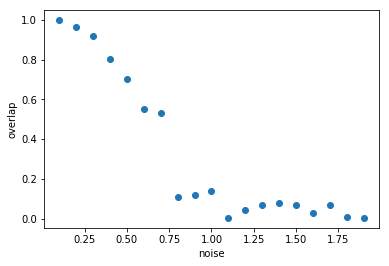

In [8]:
plt.plot(noise_vars, overlaps, "o")
plt.ylabel("overlap")
plt.xlabel("noise")

## Predicting the performance of AMP w/ state evolution

In [9]:
from scipy.integrate import quad

def iterate_se(var_noise, max_iter=250, tol=1e-11, verbose=1):
    # Define function to be integrated at each step
    f = lambda x: lambda z: np.exp(-.5 * z ** 2) / np.sqrt(2 * np.pi) * \
            np.tanh(np.sqrt(x) * z + x)
    
    m = 1e-3
    for t in range(max_iter):
        m_old = m
        m = quad(f(m / var_noise), -10, 10)[0]
        
        diff = np.abs(m - m_old)
        if verbose:
            print("t = %d, diff = %g; m = %g" % (t, diff, m))
            
        if(diff < tol):
            break
    
    return m

In [10]:
iterate_se(0.1)

t = 0, diff = 0.00890162; m = 0.00990162
t = 1, diff = 0.0806142; m = 0.0905158
t = 2, diff = 0.428603; m = 0.519118
t = 3, diff = 0.446399; m = 0.965517
t = 4, diff = 0.0315761; m = 0.997093
t = 5, diff = 0.000457241; m = 0.99755
t = 6, diff = 6.05676e-06; m = 0.997556
t = 7, diff = 8.0128e-08; m = 0.997557
t = 8, diff = 1.06004e-09; m = 0.997557
t = 9, diff = 1.40234e-11; m = 0.997557
t = 10, diff = 1.85518e-13; m = 0.997557


0.9975565759008704

In [11]:
pred_vars = np.linspace(0.01, 2, 100)
pred_overlaps = [iterate_se(var, verbose=0) for var in pred_vars]

Text(0.5,0,'noise')

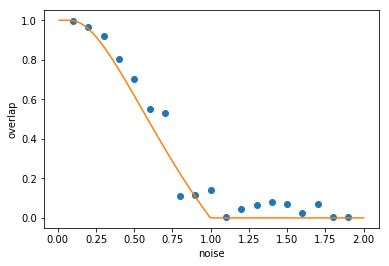

In [12]:
plt.plot(noise_vars, overlaps, "o")
plt.plot(pred_vars, pred_overlaps, "-")
plt.ylabel("overlap")
plt.xlabel("noise")

## From $xx^T$ to $XX^T$ and $UV^T$: clustering with GMMs